In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import Conv2D
from time import time
from keras.callbacks import TensorBoard, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
df1 = pd.read_hdf('df_dataDOL1.hdf', key='hdf')
df2 = pd.read_hdf('df_dataDOL2.hdf', key='hdf')
df3 = pd.read_hdf('df_dataDOL3.hdf', key='hdf')

In [4]:
df_total = pd.concat([df1,df2,df3],  ignore_index=True)

In [5]:
df_total.head()

,Data,Contratos Abertos,Contratos Fechados,Número Negócios,Contratos Negociados,Volume,Abertura,Mínimo,Máximo,Médio,Último Preço,Ajuste,Var pontos,Última oferta de compra,Última oferta de venda
0,29/07/2019,851537,719017,27192,226625,42939771125,3.7850,3.7775,3.8015,3.789499,3.7820,3.784797,145520,3.7820,3.7825
1,26/07/2019,875047,851537,32128,309480,58414828000,3.7800,3.7610,3.7955,3.775030,3.7760,3.770245,125890,3.7765,3.7780
2,25/07/2019,890941,875047,41651,381060,72105906125,3.7680,3.7570,3.8070,3.784490,3.7795,3.782834,129780,3.7795,3.7805
3,24/07/2019,883412,890941,26137,269620,50725252625,3.7675,3.7540,3.7795,3.762721,3.7735,3.769856,31160,3.7735,3.7755
4,23/07/2019,880504,883412,33586,313840,59121712875,3.7450,3.7430,3.7820,3.767634,3.7750,3.772972,356000,3.7750,3.7770


Features criadas:

-- Diferença entre Contratos abertos e fechados
-- Diferença entre Máximo e mínimo
-- Diferença entre Abertura e ùltima oferta de compra

Score models :
    adamax 32 -- 0.66
    

In [6]:
df = df_total.copy()

df['Dif_contratos'] = df['Contratos Abertos'] -df['Contratos Fechados']
df['Dif_minmax'] = (df['Máximo'] - df['Mínimo'])*1000
df['Dif_abert_ultimo'] = (df['Último Preço'] - df['Abertura'])*1000
df['Dif_abert_ajuste'] = (df['Ajuste'] - df['Abertura'])*1000

df['Contratos Negociados'] = df['Contratos Negociados']/10000
df['Número Negócios'] = df['Número Negócios']/100
df['Volume'] = df['Volume']/1000000000

df = df.drop(columns = ['Contratos Abertos', 'Contratos Fechados'])
df.head()

,Data,Número Negócios,Contratos Negociados,Volume,Abertura,Mínimo,Máximo,Médio,Último Preço,Ajuste,Var pontos,Última oferta de compra,Última oferta de venda,Dif_contratos,Dif_minmax,Dif_abert_ultimo,Dif_abert_ajuste
0,29/07/2019,271.92,22.6625,42.939771,3.7850,3.7775,3.8015,3.789499,3.7820,3.784797,145520,3.7820,3.7825,132520,24.0,-3.0,-0.203
1,26/07/2019,321.28,30.9480,58.414828,3.7800,3.7610,3.7955,3.775030,3.7760,3.770245,125890,3.7765,3.7780,23510,34.5,-4.0,-9.755
2,25/07/2019,416.51,38.1060,72.105906,3.7680,3.7570,3.8070,3.784490,3.7795,3.782834,129780,3.7795,3.7805,15894,50.0,11.5,14.834
3,24/07/2019,261.37,26.9620,50.725253,3.7675,3.7540,3.7795,3.762721,3.7735,3.769856,31160,3.7735,3.7755,-7529,25.5,6.0,2.356
4,23/07/2019,335.86,31.3840,59.121713,3.7450,3.7430,3.7820,3.767634,3.7750,3.772972,356000,3.7750,3.7770,-2908,39.0,30.0,27.972


In [63]:
#Features para adicionar

df_sp = pd.read_hdf('df_S&P500.hdf', key = 'hdf')
df_sp = df_sp[['Data', 'Contratos Negociados', 'Abertura', 'Último Preço', 'Ajuste', 'Var pontos']]
df_sp['var_abert_ultimo'] = df_sp['Último Preço'] - df_sp['Abertura']
df_sp['var_abert_ajuste'] = df_sp['Ajuste'] - df_sp['Abertura']

df_sp = df_sp.drop(columns = ['Abertura','Contratos Negociados', 'Último Preço', 'Ajuste'])
df_sp.columns = ['Data', 'Var pontos_SP', 'var_abert_ultimo_SP', 'var_abert_ajuste_SP']
df_sp

,Data,Var pontos_SP,var_abert_ultimo_SP,var_abert_ajuste_SP
0,29/07/2019,275,-0.00500,-0.00475
1,26/07/2019,1800,0.00925,0.00925
2,25/07/2019,1500,-0.02000,-0.01950
3,24/07/2019,1350,0.01775,0.02025
4,23/07/2019,1900,0.00600,0.01025
5,22/07/2019,1500,0.00550,0.00350
6,19/07/2019,2350,-0.02900,-0.02900
7,18/07/2019,1250,0.02375,0.01425
8,17/07/2019,2200,-0.02775,-0.02425
9,16/07/2019,1025,-0.01475,-0.01450


In [64]:
df = pd.merge(df, df_sp)

##### Prever relação de abertura com último preço do dia anterior

In [65]:
df_abert = df.copy()

In [66]:
#1 se a abertura do dia seguinte é maior que o fechamento e 0 se a abertura do dia seguinte é menor que o último preço

df_abert['target'] = df_abert.Abertura.shift(-1) - df_abert['Último Preço']
df_abert['target'] = df_abert['target'].apply(lambda x: 1 if x > 0 else 0)
df_abert = df_abert.drop(len(df_abert)-1)

df_abert = df_abert.drop(columns = 'Data')

In [67]:
X = df_abert.loc[:, df_abert.columns != 'target']
y = df_abert[['target']]

sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[ 1.33583836e-01, -4.91815127e-01, -6.24144569e-02, ...,
        -7.36537836e-01, -4.12293109e-01, -9.75296064e-02],
       [ 5.08041840e-01,  1.78861789e-01,  6.36623283e-01, ...,
         4.59954927e-01,  5.81168416e-01,  3.73325958e-02],
       [ 1.23048178e+00,  7.58272250e-01,  1.25507531e+00, ...,
         2.24579301e-01, -1.45804208e+00, -2.39616569e-01],
       ...,
       [-1.31046156e+00, -7.07333478e-01, -1.08559737e+00, ...,
        -5.00255952e-02,  3.02302023e-01, -1.19946198e-03],
       [-1.30712361e+00, -8.64692228e-01, -1.17247559e+00, ...,
        -6.58079294e-01,  2.15156275e-01, -1.56489836e-02],
       [-1.16040526e+00, -7.18390682e-01, -1.08871829e+00, ...,
        -6.38464659e-01, -2.90289062e-01, -8.54883383e-02]])

In [68]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
clf = LogisticRegression().fit(x_train, y_train)

predictions = clf.predict(x_test)

probas = clf.predict_proba(x_test) 


score = clf.score(x_test, y_test)
score

c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\choice\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6913946587537092

In [36]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

NameError: name 'metrics' is not defined

In [37]:
score

0.6913946587537092

Train on 1346 samples, validate on 337 samples
Epoch 1/600
1346/1346 [==============================] - 2s 2ms/step - loss: 0.6928 - acc: 0.5141 - val_loss: 0.6938 - val_acc: 0.4629
Epoch 2/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.6910 - acc: 0.5921 - val_loss: 0.6944 - val_acc: 0.4688
Epoch 3/600
1346/1346 [==============================] - 0s 64us/step - loss: 0.6867 - acc: 0.6166 - val_loss: 0.6951 - val_acc: 0.4777
Epoch 4/600
1346/1346 [==============================] - 0s 60us/step - loss: 0.6800 - acc: 0.6337 - val_loss: 0.6962 - val_acc: 0.4807
Epoch 5/600
1346/1346 [==============================] - 0s 65us/step - loss: 0.6716 - acc: 0.6367 - val_loss: 0.6965 - val_acc: 0.4926
Epoch 6/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.6629 - acc: 0.6486 - val_loss: 0.6988 - val_acc: 0.4896
Epoch 7/600
1346/1346 [==============================] - 0s 65us/step - loss: 0.6533 - acc: 0.6553 - val_loss: 0.6995 - val_acc: 0.4985
Ep

1346/1346 [==============================] - 0s 62us/step - loss: 0.5608 - acc: 0.7184 - val_loss: 0.6306 - val_acc: 0.5638
Epoch 61/600
1346/1346 [==============================] - 0s 64us/step - loss: 0.5610 - acc: 0.7192 - val_loss: 0.6196 - val_acc: 0.6142
Epoch 62/600
1346/1346 [==============================] - 0s 87us/step - loss: 0.5602 - acc: 0.7184 - val_loss: 0.6279 - val_acc: 0.5875
Epoch 63/600
1346/1346 [==============================] - 0s 90us/step - loss: 0.5604 - acc: 0.7229 - val_loss: 0.6230 - val_acc: 0.6142
Epoch 64/600
1346/1346 [==============================] - 0s 104us/step - loss: 0.5597 - acc: 0.7177 - val_loss: 0.6367 - val_acc: 0.5697
Epoch 65/600
1346/1346 [==============================] - 0s 103us/step - loss: 0.5597 - acc: 0.7199 - val_loss: 0.6346 - val_acc: 0.5638
Epoch 66/600
1346/1346 [==============================] - 0s 102us/step - loss: 0.5592 - acc: 0.7169 - val_loss: 0.6306 - val_acc: 0.5905
Epoch 67/600
1346/1346 [===========================

Epoch 120/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.5493 - acc: 0.7192 - val_loss: 0.6213 - val_acc: 0.6142
Epoch 121/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.5514 - acc: 0.7214 - val_loss: 0.6330 - val_acc: 0.5905
Epoch 122/600
1346/1346 [==============================] - 0s 65us/step - loss: 0.5495 - acc: 0.7214 - val_loss: 0.6257 - val_acc: 0.6053
Epoch 123/600
1346/1346 [==============================] - 0s 66us/step - loss: 0.5497 - acc: 0.7184 - val_loss: 0.6430 - val_acc: 0.5816
Epoch 124/600
1346/1346 [==============================] - 0s 68us/step - loss: 0.5496 - acc: 0.7192 - val_loss: 0.6389 - val_acc: 0.5786
Epoch 125/600
1346/1346 [==============================] - 0s 70us/step - loss: 0.5494 - acc: 0.7221 - val_loss: 0.6292 - val_acc: 0.5964
Epoch 126/600
1346/1346 [==============================] - 0s 82us/step - loss: 0.5495 - acc: 0.7221 - val_loss: 0.6257 - val_acc: 0.6053
Epoch 127/600
1346/1346 [=========

1346/1346 [==============================] - 0s 78us/step - loss: 0.5447 - acc: 0.7214 - val_loss: 0.6242 - val_acc: 0.6053
Epoch 180/600
1346/1346 [==============================] - 0s 62us/step - loss: 0.5434 - acc: 0.7229 - val_loss: 0.6221 - val_acc: 0.6113
Epoch 181/600
1346/1346 [==============================] - 0s 73us/step - loss: 0.5435 - acc: 0.7251 - val_loss: 0.6172 - val_acc: 0.6202
Epoch 182/600
1346/1346 [==============================] - 0s 76us/step - loss: 0.5435 - acc: 0.7229 - val_loss: 0.6173 - val_acc: 0.6202
Epoch 183/600
1346/1346 [==============================] - 0s 79us/step - loss: 0.5432 - acc: 0.7251 - val_loss: 0.6020 - val_acc: 0.6409
Epoch 184/600
1346/1346 [==============================] - 0s 77us/step - loss: 0.5440 - acc: 0.7236 - val_loss: 0.6059 - val_acc: 0.6350
Epoch 185/600
1346/1346 [==============================] - 0s 90us/step - loss: 0.5432 - acc: 0.7266 - val_loss: 0.6170 - val_acc: 0.6231
Epoch 186/600
1346/1346 [=======================

1346/1346 [==============================] - 0s 77us/step - loss: 0.5409 - acc: 0.7236 - val_loss: 0.6046 - val_acc: 0.6320
Epoch 239/600
1346/1346 [==============================] - 0s 97us/step - loss: 0.5413 - acc: 0.7273 - val_loss: 0.6153 - val_acc: 0.6142
Epoch 240/600
1346/1346 [==============================] - 0s 72us/step - loss: 0.5411 - acc: 0.7236 - val_loss: 0.6143 - val_acc: 0.6172
Epoch 241/600
1346/1346 [==============================] - 0s 76us/step - loss: 0.5415 - acc: 0.7244 - val_loss: 0.6119 - val_acc: 0.6172
Epoch 242/600
1346/1346 [==============================] - 0s 85us/step - loss: 0.5411 - acc: 0.7214 - val_loss: 0.6139 - val_acc: 0.6172
Epoch 243/600
1346/1346 [==============================] - 0s 96us/step - loss: 0.5411 - acc: 0.7177 - val_loss: 0.6188 - val_acc: 0.6083
Epoch 244/600
1346/1346 [==============================] - 0s 101us/step - loss: 0.5410 - acc: 0.7251 - val_loss: 0.6267 - val_acc: 0.6053
Epoch 245/600
1346/1346 [======================

1346/1346 [==============================] - 0s 82us/step - loss: 0.5390 - acc: 0.7229 - val_loss: 0.6195 - val_acc: 0.6083
Epoch 298/600
1346/1346 [==============================] - 0s 74us/step - loss: 0.5397 - acc: 0.7192 - val_loss: 0.6378 - val_acc: 0.5994
Epoch 299/600
1346/1346 [==============================] - 0s 76us/step - loss: 0.5386 - acc: 0.7184 - val_loss: 0.6274 - val_acc: 0.6113
Epoch 300/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.5391 - acc: 0.7199 - val_loss: 0.6276 - val_acc: 0.6113
Epoch 301/600
1346/1346 [==============================] - 0s 66us/step - loss: 0.5390 - acc: 0.7221 - val_loss: 0.6253 - val_acc: 0.6113
Epoch 302/600
1346/1346 [==============================] - 0s 62us/step - loss: 0.5391 - acc: 0.7199 - val_loss: 0.6363 - val_acc: 0.5994
Epoch 303/600
1346/1346 [==============================] - 0s 62us/step - loss: 0.5390 - acc: 0.7221 - val_loss: 0.6210 - val_acc: 0.6202
Epoch 304/600
1346/1346 [=======================

1346/1346 [==============================] - 0s 64us/step - loss: 0.5368 - acc: 0.7214 - val_loss: 0.6078 - val_acc: 0.6320
Epoch 357/600
1346/1346 [==============================] - 0s 61us/step - loss: 0.5368 - acc: 0.7251 - val_loss: 0.6029 - val_acc: 0.6409
Epoch 358/600
1346/1346 [==============================] - 0s 60us/step - loss: 0.5373 - acc: 0.7199 - val_loss: 0.6073 - val_acc: 0.6320
Epoch 359/600
1346/1346 [==============================] - 0s 64us/step - loss: 0.5381 - acc: 0.7177 - val_loss: 0.6084 - val_acc: 0.6261
Epoch 360/600
1346/1346 [==============================] - 0s 124us/step - loss: 0.5379 - acc: 0.7184 - val_loss: 0.6124 - val_acc: 0.6261
Epoch 361/600
1346/1346 [==============================] - 0s 69us/step - loss: 0.5373 - acc: 0.7221 - val_loss: 0.5967 - val_acc: 0.6439
Epoch 362/600
1346/1346 [==============================] - 0s 59us/step - loss: 0.5373 - acc: 0.7221 - val_loss: 0.6011 - val_acc: 0.6350
Epoch 363/600
1346/1346 [======================

1346/1346 [==============================] - 0s 78us/step - loss: 0.5343 - acc: 0.7177 - val_loss: 0.6016 - val_acc: 0.6409
Epoch 416/600
1346/1346 [==============================] - 0s 84us/step - loss: 0.5348 - acc: 0.7273 - val_loss: 0.6040 - val_acc: 0.6380
Epoch 417/600
1346/1346 [==============================] - 0s 76us/step - loss: 0.5352 - acc: 0.7207 - val_loss: 0.6025 - val_acc: 0.6409
Epoch 418/600
1346/1346 [==============================] - 0s 71us/step - loss: 0.5341 - acc: 0.7207 - val_loss: 0.5978 - val_acc: 0.6439
Epoch 419/600
1346/1346 [==============================] - 0s 95us/step - loss: 0.5340 - acc: 0.7177 - val_loss: 0.6022 - val_acc: 0.6380
Epoch 420/600
1346/1346 [==============================] - 0s 105us/step - loss: 0.5339 - acc: 0.7177 - val_loss: 0.5997 - val_acc: 0.6528
Epoch 421/600
1346/1346 [==============================] - 0s 115us/step - loss: 0.5355 - acc: 0.7169 - val_loss: 0.5928 - val_acc: 0.6558
Epoch 422/600
1346/1346 [=====================

1346/1346 [==============================] - 0s 97us/step - loss: 0.5324 - acc: 0.7147 - val_loss: 0.6108 - val_acc: 0.6409
Epoch 475/600
1346/1346 [==============================] - 0s 85us/step - loss: 0.5331 - acc: 0.7110 - val_loss: 0.6044 - val_acc: 0.6528
Epoch 476/600
1346/1346 [==============================] - 0s 82us/step - loss: 0.5334 - acc: 0.7125 - val_loss: 0.6146 - val_acc: 0.6350
Epoch 477/600
1346/1346 [==============================] - 0s 77us/step - loss: 0.5320 - acc: 0.7177 - val_loss: 0.5978 - val_acc: 0.6647
Epoch 478/600
1346/1346 [==============================] - 0s 91us/step - loss: 0.5322 - acc: 0.7155 - val_loss: 0.5980 - val_acc: 0.6528
Epoch 479/600
1346/1346 [==============================] - 0s 108us/step - loss: 0.5332 - acc: 0.7162 - val_loss: 0.6120 - val_acc: 0.6380
Epoch 480/600
1346/1346 [==============================] - 0s 101us/step - loss: 0.5325 - acc: 0.7169 - val_loss: 0.6019 - val_acc: 0.6499
Epoch 481/600
1346/1346 [=====================

1346/1346 [==============================] - 0s 88us/step - loss: 0.5312 - acc: 0.7169 - val_loss: 0.5999 - val_acc: 0.6617
Epoch 534/600
1346/1346 [==============================] - 0s 79us/step - loss: 0.5308 - acc: 0.7169 - val_loss: 0.5988 - val_acc: 0.6617
Epoch 535/600
1346/1346 [==============================] - 0s 79us/step - loss: 0.5305 - acc: 0.7169 - val_loss: 0.5957 - val_acc: 0.6617
Epoch 536/600
1346/1346 [==============================] - 0s 81us/step - loss: 0.5313 - acc: 0.7147 - val_loss: 0.5974 - val_acc: 0.6677
Epoch 537/600
1346/1346 [==============================] - 0s 73us/step - loss: 0.5315 - acc: 0.7132 - val_loss: 0.6040 - val_acc: 0.6558
Epoch 538/600
1346/1346 [==============================] - 0s 74us/step - loss: 0.5306 - acc: 0.7169 - val_loss: 0.6049 - val_acc: 0.6469
Epoch 539/600
1346/1346 [==============================] - 0s 74us/step - loss: 0.5322 - acc: 0.7147 - val_loss: 0.5976 - val_acc: 0.6647
Epoch 540/600
1346/1346 [=======================

1346/1346 [==============================] - 0s 85us/step - loss: 0.5310 - acc: 0.7162 - val_loss: 0.6087 - val_acc: 0.6558
Epoch 593/600
1346/1346 [==============================] - 0s 88us/step - loss: 0.5293 - acc: 0.7192 - val_loss: 0.6001 - val_acc: 0.6677
Epoch 594/600
1346/1346 [==============================] - 0s 109us/step - loss: 0.5288 - acc: 0.7162 - val_loss: 0.6023 - val_acc: 0.6677
Epoch 595/600
1346/1346 [==============================] - 0s 84us/step - loss: 0.5299 - acc: 0.7155 - val_loss: 0.5899 - val_acc: 0.6825
Epoch 596/600
1346/1346 [==============================] - 0s 87us/step - loss: 0.5294 - acc: 0.7132 - val_loss: 0.6068 - val_acc: 0.6588
Epoch 597/600
1346/1346 [==============================] - 0s 101us/step - loss: 0.5296 - acc: 0.7162 - val_loss: 0.5883 - val_acc: 0.6766
Epoch 598/600
1346/1346 [==============================] - 0s 85us/step - loss: 0.5299 - acc: 0.7177 - val_loss: 0.6007 - val_acc: 0.6677
Epoch 599/600
1346/1346 [=====================

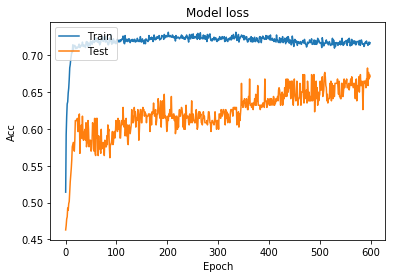

In [62]:
model = Sequential()
model.add(Dense(2, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(2, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=600, validation_split = 0.2)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Train on 1514 samples, validate on 169 samples
Epoch 1/100
1514/1514 [==============================] - 2s 1ms/step - loss: 0.6847 - acc: 0.5581 - val_loss: 0.6867 - val_acc: 0.4734
Epoch 2/100
1514/1514 [==============================] - 0s 71us/step - loss: 0.6581 - acc: 0.6057 - val_loss: 0.6876 - val_acc: 0.4793
Epoch 3/100
1514/1514 [==============================] - 0s 78us/step - loss: 0.6329 - acc: 0.6572 - val_loss: 0.6687 - val_acc: 0.4675
Epoch 4/100
1514/1514 [==============================] - 0s 79us/step - loss: 0.6074 - acc: 0.6909 - val_loss: 0.6461 - val_acc: 0.5858
Epoch 5/100
1514/1514 [==============================] - 0s 78us/step - loss: 0.5855 - acc: 0.7081 - val_loss: 0.6173 - val_acc: 0.6746
Epoch 6/100
1514/1514 [==============================] - 0s 84us/step - loss: 0.5700 - acc: 0.7120 - val_loss: 0.6094 - val_acc: 0.6568
Epoch 7/100
1514/1514 [==============================] - 0s 84us/step - loss: 0.5621 - acc: 0.7153 - val_loss: 0.5975 - val_acc: 0.6746
Ep

Epoch 60/100
1514/1514 [==============================] - 0s 87us/step - loss: 0.5122 - acc: 0.7351 - val_loss: 0.5858 - val_acc: 0.6450
Epoch 61/100
1514/1514 [==============================] - 0s 94us/step - loss: 0.5104 - acc: 0.7450 - val_loss: 0.5667 - val_acc: 0.6805
Epoch 62/100
1514/1514 [==============================] - 0s 107us/step - loss: 0.5100 - acc: 0.7391 - val_loss: 0.5779 - val_acc: 0.6746
Epoch 63/100
1514/1514 [==============================] - 0s 88us/step - loss: 0.5095 - acc: 0.7417 - val_loss: 0.5854 - val_acc: 0.6568
Epoch 64/100
1514/1514 [==============================] - 0s 92us/step - loss: 0.5101 - acc: 0.7444 - val_loss: 0.5566 - val_acc: 0.7337
Epoch 65/100
1514/1514 [==============================] - 0s 103us/step - loss: 0.5093 - acc: 0.7411 - val_loss: 0.5815 - val_acc: 0.6627
Epoch 66/100
1514/1514 [==============================] - 0s 86us/step - loss: 0.5084 - acc: 0.7391 - val_loss: 0.5677 - val_acc: 0.6746
Epoch 67/100
1514/1514 [===============

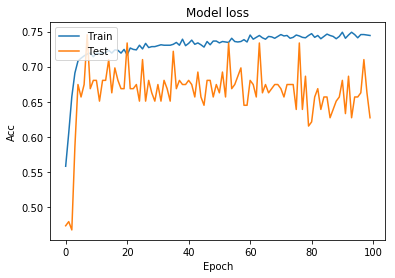

In [57]:
model = Sequential()
model.add(Dense(16, kernel_initializer='normal', input_dim=len(X[0]), activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X, y.values, epochs=100, validation_split = 0.1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model loss')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()